This file implements DTW, Subsequence DTW, NSDTW, WSDTW, and SSDTW

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit, njit, float64, uint32, boolean

## DTW and Subsequence DTW

In [3]:
DTWDefaultSteps = np.array([[1, 1, 2],
                            [1, 2, 1]], dtype = np.uint32)

DTWDefaultWeights = np.array([2, 3, 3], dtype = np.float64)


subseqDTWDefaultSteps = np.array([[1, 1, 2],
                                  [1, 2, 1]], dtype = np.uint32)

subseqDTWDefaultWeights = np.array([1, 1, 2], dtype = np.float64)


MAX_FLOAT = float('inf')

In [4]:
# njit is equivalent to jit(nopython=True)
# This forces numba to compile in nopython mode, which is faster

# This line enforces input types. However, it does not work with optional parameters
#@njit((float64[:,::1], uint32[:,::1], float64[:], boolean))

@njit
def DTW_Cost_To_DandB(C, Steps = DTWDefaultSteps, weights = DTWDefaultWeights, subsequence=False):
    '''
    Find the accumulated cost matrix and backtrace matrix from a cost matrix using Dynamic time warping
    
    Arguments:
    C -- The Cost matrix
    Steps -- The available steps, where the first row is the row steps, the second row is the column steps
    weights -- The weights of the steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
             
    Returns:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    '''
    '''
    Section for verifying input
    '''
    # Ensure parameters have correct dtypes and dimensions
    try:
        C = C.astype(np.float64)
        assert C.ndim == 2
    except:
        print("FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        weights = weights.astype(np.float64)
        assert weights.ndim == 1
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return
    
    # Ensure steps and weights sizes are appropriate
    stepsShape = Steps.shape
    numDifSteps = len(weights)
    
    if stepsShape[0] != 2:
        print("FAILURE: The size of the steps matrix is wrong - please pass in a 2-d numpy array with 2 rows")
        return
    if stepsShape[1] != numDifSteps:
        print("FAILURE: The number of steps and weights do not line up - please make sure that there are the same number of steps and weights")
        return
    
    '''
    Algorithm
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]

    # Define Relevant Variables
    numRows = C.shape[0]
    numCols = C.shape[1]
    
    numDifSteps = len(weights)
    maxRowStep = max(rowSteps)
    maxColStep = max(colSteps)
    
    # Set up accumulated cost matrix D and backtrace matrix B
    D = np.ones((numRows + maxRowStep, numCols + maxColStep), dtype = np.float64) * MAX_FLOAT
    B = np.zeros((numRows, numCols), dtype = np.uint32)
    
    # Fill up D and B
    if subsequence:  # Initialize entire bottom row of D for subsequence
        D[maxRowStep, maxColStep:] = C[0,:]
    else:
        D[maxRowStep, maxColStep] = C[0,0]  # Initialize bottom corner if for standard DTW
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = D[row, col]
            bestCostIndex = 0
            # Go through each step, find the best one
            for stepIndex in range(numDifSteps):
                costForStep = D[row - rowSteps[stepIndex], col - colSteps[stepIndex]] + weights[stepIndex] * C[row - maxRowStep, col - maxColStep]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # Save best cost and step
            D[row,col] = bestCost
            B[row - maxRowStep, col - maxColStep] = bestCostIndex
    
    # Return accumulated cost matrix D and backtrace matrix B
    return D[maxRowStep:, maxColStep:], B

In [5]:
# This line enforces input types. However, it does not work with optional parameters
#@njit((float64[:,::1], uint32[:,::1], uint32[:,::1], boolean, uint32))

@njit
def DTW_Backtrace(D, B, Steps=DTWDefaultSteps, subsequence=False, startCol=-1):
    '''
    Backtrace through an accumulated cost matrix and backtrace matrix to find a path
    
    Arguments:
    D -- The accumulated cost matrix
    B -- The backtrace matrix
    Steps -- The available steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
    startCol -- The column to begin backtracing from, or -1 if not specified
    
    Returns:
    fwdPath -- A 2d numpy array storing the optimal path. The first row is the path through the rows.
            The second row is the path through the columns
    '''
    '''
    Section for verifying input
    '''
    # Ensure parameters have correct dtypes and dimensions
    try:
        D = D.astype(np.float64)
        assert D.ndim == 2
    except:
        print("FAILURE: The type of the accumulated cost matrix is wrong - please pass in a 2-d numpy array")
        return

    try:
        B = B.astype(np.uint32)
        assert B.ndim == 2
    except:
        print("FAILURE: The type of the backtrace matrix is wrong - please pass in a 2-d numpy array")
        return
    
    try:
        Steps = Steps.astype(np.uint32)
        assert Steps.ndim == 2
    except:
        print("FAILURE: The type of the steps matrix is wrong - please pass in a 2-d numpy array")
        return

    # Ensure that D and B are the same shape
    if D.shape != B.shape:
        print("FAILURE: The accumulated cost matrix and backtrace matrix are not the same size - please make sure their sizes match")
        return
    
    
    '''
    Backtrace through D and B
    '''
    # Separate steps
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]
    
    # Initialize variables
    numRows = D.shape[0]
    numCols = D.shape[1]
    
    curRow = numRows - 1  # Always start at last row
    curCol = numCols - 1  # Standard DTW: Start at top-right corner
    if startCol > 0:
        curCol = startCol
    elif subsequence:  # Subsequence: Choose lowest cost of top row
        curCol = np.argmin(D[numRows-1,:])
    
    endCol = curCol
    endCost = D[curRow, curCol]
    stepsInPath = 1
    stepIndex = 0
    done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
    path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol
    
    # Backtrace
    while not done:
        if D[curRow, curCol] == MAX_FLOAT:  # No path exists to current location
            return
        
        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = B[curRow, curCol]
        curRowStep = rowSteps[curStepIndex]
        curColStep = colSteps[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subsequence and curRow == 0) or (curRow == 0 and curCol == 0)
        
    # reverse the path (a matrix with two rows) and return it
    fwdPath = np.fliplr(path[:, 0:stepsInPath])
    return fwdPath
    #return fwdPath, endCol, endCost

In [6]:
@njit
def DTW(F1, F2, Steps = DTWDefaultSteps, weights = DTWDefaultWeights, subsequence = False):
    '''
    Run DTW on two feature matrices
    
    Arguments:
    F1 -- Feature Matrix 1
    F2 -- Feature Matrix 2
    Steps -- The steps matrix. The first row is the steps in along the rows,
             the second row is the steps along the columns
    weights -- The weights for the steps
    subsequence -- True if subsequence DTW should be performed rather than standard DTW
    
    Returns:
    path -- A 2d numpy array storing the optimal path. The first row is the path through the rows.
            The second row is the path through the columns
    '''
    # Compute Cost Matrix
    C = 1 - F1.T @ F2 # cos distance metric
    
    # Get D and B
    D, B = DTW_Cost_To_DandB(C, Steps = Steps, weights = weights, subsequence=subsequence)
    
    # Backtrace and return
    return DTW_Backtrace(D, B, Steps=Steps, subsequence=subsequence)

### Test DTW on Random Feature Matrices

In [7]:
def genRandomFeatures(outdir):
    '''
    Generate random feature matrices and save them to outdir
    
    Arguments:
    outdir -- The directory to save the two feature matrices
    '''
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    F1 = np.random.rand(12, 10000)
    norm_factor = np.sqrt(np.sum(F1*F1, axis=0))
    F1 = F1 / norm_factor

    F2 = np.random.rand(12, 10000)
    norm_factor = np.sqrt(np.sum(F2*F2, axis=0))
    F2 = F2 / norm_factor
    
    F3 = np.random.rand(12, 1000)
    norm_factor = np.sqrt(np.sum(F3*F3, axis=0))
    F3 = F3 / norm_factor

    F4 = np.random.rand(12, 1000)
    norm_factor = np.sqrt(np.sum(F4*F4, axis=0))
    F4 = F4 / norm_factor

    
    np.save(outdir / "Features_1.npy", F1)
    np.save(outdir / "Features_2.npy", F2)
    np.save(outdir / "Features_3.npy", F3)
    np.save(outdir / "Features_4.npy", F4)

In [8]:
# Make and save random features
#genRandomFeatures(Path("test_features"))
# Run this ^ once to create files for testing
outdir = Path("implementation_test/test_features")

F1 = np.load("implementation_test/test_features/Features_1.npy", allow_pickle=True)
F2 = np.load("implementation_test/test_features/Features_2.npy", allow_pickle=True)
F3 = np.load("implementation_test/test_features/Features_3.npy", allow_pickle=True)
F4 = np.load("implementation_test/test_features/Features_4.npy", allow_pickle=True)


In [9]:
path = DTW(F1, F2)

In [10]:
_, wp = lb.sequence.dtw(F1, F2, metric = 'cosine', step_sizes_sigma=DTWDefaultSteps.T, weights_mul = DTWDefaultWeights)

In [11]:
np.allclose(path, np.fliplr(wp.T))

True

As desired, our implementation's output matches the output from librosa

### Test Subsequence DTW on Random Feature Matrices

In [12]:
SDTWpath = DTW(F1[0:2000], F2, Steps = subseqDTWDefaultSteps, weights=subseqDTWDefaultWeights, subsequence=True)

In [13]:
_, SDTWwp = lb.sequence.dtw(F1[0:2000], F2, metric = 'cosine', step_sizes_sigma=subseqDTWDefaultSteps.T, weights_mul = subseqDTWDefaultWeights, subseq=True)

In [14]:
np.allclose(SDTWpath, np.fliplr(SDTWwp.T))

True

As desired, our implementation's output matches the output from librosa

## Non-ordered Segmental DTW

In [15]:
@njit
def NSDTW(F1, F2, segments, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights):
    '''
    Runs a non-ordered segmental DTW between query and reference features matrices
    NOTE: This implementation assumes features have already been computed (As is done in the prep file)
    
    Arguments:
    F1 -- The query features matrix (will be segmented)
    F2 -- The reference features matrix
    segments -- The number of segments to divide F1 into
    Steps -- The allowed steps
    weights -- The weights for the steps
    
    Returns:
    path -- The optimal non-ordered, segmented alignment path between F1 and F2
    '''
    # Initialize path
    # make as large as could need, then chop at the end
    path = np.zeros((2, F1.shape[1] + (segments * F2.shape[1])), dtype=np.uint32)
    stepsInPath = 0
    
    segLength = int(np.ceil(F1.shape[1] / segments))
    
    # Subsequence DTW each segment
    for i in range(segments):
        segStart = i * segLength
        # Ensuring that the segment is contiguous here ensures best performance when computing cost later
        currentSeg = np.ascontiguousarray(F1[:,segStart:min(segStart + segLength,F1.shape[1])])
        pathSeg = DTW(currentSeg, F2, Steps = Steps, weights = weights, subsequence = True)
        
        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + segStart
        
        # Append fragment to full path
        stepsInPathSeg = pathSeg.shape[1]
        path[:,stepsInPath:stepsInPath+stepsInPathSeg] = pathSeg
        # stepsInPath keeps track of how long the path is, and where to put new path segments
        stepsInPath = stepsInPath + stepsInPathSeg
    
    # Chop off any extra space at the end of the path
    return path[:,:stepsInPath]

### Testing NSDTW on Random Feature Matrices

In [16]:
NSDTWPath = NSDTW(F1, F2, 5)

In [17]:
C = 1 - F1.T @ F2

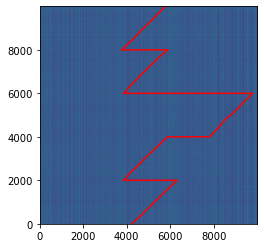

In [18]:
plt.imshow(C, origin="lower");
plt.plot(NSDTWPath[1,:], NSDTWPath[0,:], 'r');

NOTE: I do not have anything to compare this to, but it seems visually correct

## Weakly-ordered Segmental DTW

In [19]:
@njit
def getSegmentEndingLocs(wp):
    '''
    Takes in a segment level path through and returns the columns where each segment ends
    
    Arguments:
    wp -- A segment level path (as a 2d numpy array with 2 rows)
    
    Returns:
    endLocs -- A list where the ith entry is the column where the ith segment ends
    '''
    prevLoc = wp[:,0] # [r,c]
    endLocs = []
    for i in range(wp.shape[1]):
        curLoc = wp[:,i]
        if curLoc[0] != prevLoc[0]: # if row changes
            endLocs.append(curLoc[1])
        prevLoc = curLoc
        
    return endLocs

In [20]:
@njit
def WSDTW(F1, F2, segments, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights):
    '''
    Runs a weakly-ordered segmental DTW between query and reference features matrices
    
    Arguments:
    F1 -- The query features matrix (will be segmented)
    F2 -- The reference features matrix
    segments -- The number of segments to divide F1 into
    Steps -- The allowed steps
    weights -- The weights for the steps
    
    Returns:
    path -- The optimal weakly-ordered, segmented alignment path between F1 and F2
    '''

    if max(F1.shape[1], F2.shape[1]) / min(F1.shape[1], F2.shape[1]) >= 2: # no valid path possible
        print("FAILURE - Feature sizes are too different to align with DTW")
        return
    
    # Compute Cost
    # NOTE: This could also be done segment by segment.
    # I am doing it all up front to match the implementation in the old code.
    C = 1 - F1.T @ F2
    
    # Subsequence DTW each segment without backtracing
    segLength = int(np.ceil(F1.shape[1] / segments))
    Cseg = np.zeros((segments + 1, C.shape[1]), dtype = np.float64)
    Dparts = []
    Bparts = []
    for i in range(segments):
        segStart = i * segLength
        segEnd = min(segStart + segLength, C.shape[0])
        # Ensuring that the segment is contiguous here ensures best performance in later computations
        currentSeg = np.ascontiguousarray(C[segStart:segEnd,:])
        D_i, B_i = DTW_Cost_To_DandB(currentSeg, Steps = Steps, weights = weights, subsequence = True)
        
        # Store D_i and B_i for segment and construct Cseg
        Dparts.append(D_i)
        Bparts.append(B_i)
        
        # NOTE: May need to separate this into a different loop for runtime profiling
        Cseg[i + 1,:] = D_i[-1,:]

    # run segment-level DTW (Not subsequence)
    segmentSteps = np.array([[0, 1],
                             [1, C.shape[0]//(2 * segments)]], #NOTE: This could cause differences with old implementation
                            dtype=np.uint32)
    segmentWeights = np.array([0, 1])
    
    Dseg, Bseg = DTW_Cost_To_DandB(Cseg, Steps = segmentSteps, weights = segmentWeights)
    wpseg = DTW_Backtrace(Dseg, Bseg, Steps=segmentSteps)
    
    # Backtrace through segments with segment level path as guide
    # Initialize path: make as large as could need, then chop at the end
    path = np.zeros((2, F1.shape[1] + (segments * F2.shape[1])), dtype=np.uint32)
    stepsInPath = 0
    # Frame level backtrace segment by segment
    segmentEndIdxs = getSegmentEndingLocs(wpseg)
    for i, endidx in enumerate(segmentEndIdxs):
        pathSeg = DTW_Backtrace(Dparts[i], Bparts[i], Steps = Steps, subsequence = True, startCol = endidx)
        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + (i * segLength)

        # Append fragment to full path
        stepsInPathSeg = pathSeg.shape[1]
        path[:,stepsInPath:stepsInPath+stepsInPathSeg] = pathSeg
        # stepsInPath keeps track of how long the path is, and where to put new path segments
        stepsInPath = stepsInPath + stepsInPathSeg

    return path[:,:stepsInPath]

### Testing WSDTW Results

In [21]:
WSDTWPath = WSDTW(F1, F2, 5)

I will compare to results found using the cython implementation on the same random features matrices. Note that this will fail if the cython implementation hasn't been run the features

In [22]:
cythonWSDTWPath = np.load("implementation_test/cython_results/WSDTW", allow_pickle = True)
np.allclose(cythonWSDTWPath,WSDTWPath)

True

In [23]:
#plt.imshow(C, origin="lower");
#plt.plot(WSDTWPath[1,:], WSDTWPath[0,:], 'r');

The numba and cython implementations match :)

## Strongly-ordered Segmental DTW

In [24]:
@njit
def SSDTW_Segment_Level_DTW(Cseg, Tseg):
    '''
    Performs the segment level DTW for strongly-ordered segmental DTW
    Steps not required because they are variable based on Tseg
    
    Arguments:
    Cseg -- The segment level cost matrix
    Tseg -- A matrix where the i,jth entry is the column of the optimal path through segment i ending at column j.
            This is used to determine the possible segment level steps that ensure strong ordering
            
    Returns:
    Dseg -- The segment level accumulated cost matrix
    Bseg -- The segment level backtrace matrix. Since steps are variable, the i, jth entry of the backtrace matrix
            stores either -1 for a (1, 0) "skip" step or the colStep value of a (1, colStep) step ending at i,j
    '''

    # Define Relevant Variables
    numRows = Cseg.shape[0]
    numCols = Cseg.shape[1]
    
    # Set up accumulated cost matrix D and backtrace matrix B
    Dseg = np.ones((numRows + 1, numCols + 1), dtype = np.float64) * MAX_FLOAT
    Dseg[0,:] = 0
    
    # (0,1) transition by default
    Bseg = np.zeros((numRows+1, numCols), dtype = np.int32) - 1
    
    # Fill up D and B
    for row in range(1, numRows+1):
        for col in range(1, numCols+1):
            # (0,1) transition is skip with weight 0
            skipCost = Dseg[row, col-1]
            Dseg[row, col] = skipCost
            
            traverseStartCol = Tseg[row-1,col-1]
            if traverseStartCol >= 0: # is it possible to traverse previous segment and end up here?
                # Traverse segment with weight 1
                traverseSegCost = Dseg[row-1, traverseStartCol] + Cseg[row-1, col-1]
                # If traversing here is best option, store the column where the path starts
                if traverseSegCost < skipCost:
                    Dseg[row, col] = traverseSegCost
                    # TraverseStartCol represents where to start backtracing in the next row
                    Bseg[row, col-1] = traverseStartCol
    
    return Dseg[:,1:], Bseg

In [25]:
@njit
def SSDTW_Segment_Level_Backtrace(Dseg, Bseg):
    '''
    Backtraces through segments enforcing a strongly-ordered path
    
    Arguments:
    Dseg -- The segmental accumulated cost matrix
    Bseg -- The segmental backtrace matrix. Stores -1 for (0,1) transitions and colStep for (1, colStep) transitions
    
    Returns:
    path -- A vector where the ith element is the column where the ith segment should end
    '''
    # Initialize variables
    numRows = Dseg.shape[0]
    numCols = Dseg.shape[1]
    curRow = numRows - 1
    curCol = numCols - 1
    # Path will have one entry for every row except for the bottom one
    path = np.zeros(numRows-1, dtype = np.uint32)
    stepsInPath = 0
    
    # Backtrace until reaching bottom row
    while curRow > 0:
        # (1,0) "skip" transitions (-1 in Bseg) do not get added to path
        if Bseg[curRow, curCol] < 0:
            curCol = curCol - 1
        # For segment traversals, store segment end location in the path.
        else:
            path[stepsInPath] = curCol
            # Continue backtracing where the segment tranversal began
            curCol = Bseg[curRow, curCol]
            curRow = curRow - 1
            stepsInPath = stepsInPath + 1
    # Remember to flip the backtraced path
    return path[::-1]

In [26]:
@njit
def calcTseg(D_i, B_i, Steps = subseqDTWDefaultSteps):
    '''
    Calculate a row of Tseg for SSDTW from the the accumulated cost and backtrace matrix for that segment
    
    Arguments:
    D_i -- The accumulated cost matrix for the ith segment
    B_i -- The backtrace matrix for the ith segment
    Steps -- The available steps
    
    Returns:
    Tseg_i -- The ith row of Tseg
    '''
    # Initializing variables
    numRows = D_i.shape[0]
    numCols = D_i.shape[1]
    rowSteps = Steps[0,:]
    colSteps = Steps[1,:]
    # Default to -1, meaning no path ending at that location is possible
    Tseg_i = np.zeros(numCols, dtype = np.uint32) - 1
    
    # Fill in Tseg_i by backtracing from each column
    # backtrace from every location
    for endCol in range(numCols):
        curCol = endCol
        curRow = numRows - 1
        while curRow > 0:
            if D_i[curRow, curCol] == MAX_FLOAT: # no valid path
                Tseg_i[curCol] = -1
                break

            curStepIndex = B_i[curRow, curCol]
            curRow = curRow - rowSteps[curStepIndex]
            curCol = curCol - colSteps[curStepIndex]
            if curRow == 0:
                Tseg_i[endCol] = curCol
    
    return Tseg_i

In [27]:
@njit
def SSDTW(F1, F2, segments, Steps = subseqDTWDefaultSteps, weights = subseqDTWDefaultWeights):
    '''
    Aligns F1 and F2 with strictly-ordered segmental DTW
    
    Arguments:
    F1 -- The query features matrix
    F2 -- The reference features matrix
    segments -- The number of segments
    Steps -- The allowable steps
    weights -- The weights of the steps
    
    Returns:
    path -- The optimal strictly ordered segmental path
    '''

    # NOTE: This swap comes from the old code.
    # It is not mentioned in the paper but seems important because of the strictly increasing nature of the path
    # The swap is undone at the end of the function
    swap = (F1.shape[1] > F2.shape[1])
    if swap:
        F1, F2 = F2, F1 # make the shorter sequence the query

    if F2.shape[1] / F1.shape[1] >= 2: # no valid path possible
        print("FAILURE - Feature sizes are too different to align with DTW")
        return
    
    # Compute Cost
    # NOTE: This could also be done segment by segment.
    # I am doing it all up front to match the implementation in the old code.
    C = 1 - F1.T @ F2
    # Subsequence DTW each segment without backtracing
    segLength = int(np.ceil(F1.shape[1] / segments))
    Cseg = np.zeros((segments, C.shape[1]), dtype = np.float64)
    Tseg = np.zeros((segments, F2.shape[1]), dtype=np.int32)
    Dparts = []
    Bparts = []

    for i in range(segments):
        segStart = i * segLength
        segEnd = min(segStart + segLength, C.shape[0])
        # Ensuring that the segment is contiguous here ensures best performance in later computations
        currentSeg = np.ascontiguousarray(C[segStart:segEnd,:])
        D_i, B_i = DTW_Cost_To_DandB(currentSeg, Steps = Steps, weights = weights, subsequence = True)
        
        # Store D_i and B_i for segment and construct Cseg
        Dparts.append(D_i)
        Bparts.append(B_i)
        
        # NOTE: May need to separate these into different loop for runtime profiling
        Cseg[i,:] = D_i[-1,:]
        Tseg[i,:] = calcTseg(D_i, B_i, Steps=Steps)

    # run segment-level DTW (Not subsequence)
    Dseg, Bseg = SSDTW_Segment_Level_DTW(Cseg, Tseg)
    segmentEndIdxs = SSDTW_Segment_Level_Backtrace(Dseg, Bseg)
    
    # Frame level backtrace segment by segment
    # Initialize path: make as large as could need, then chop at the end
    path = np.zeros((2, F1.shape[1] + F2.shape[1]), dtype=np.uint32)
    stepsInPath = 0
    for i, endidx in enumerate(segmentEndIdxs):
        pathSeg = DTW_Backtrace(Dparts[i], Bparts[i], Steps = Steps, subsequence = True, startCol = endidx)

        # Add offset to row indices so they match with overall path
        pathSeg[0,:] = pathSeg[0,:] + (i * segLength)

        # Append fragment to full path
        stepsInPathSeg = pathSeg.shape[1]
        path[:,stepsInPath:stepsInPath+stepsInPathSeg] = pathSeg
        
        # stepsInPath keeps track of how long the path is, and where to put new path segments
        stepsInPath = stepsInPath + stepsInPathSeg

    # Again, this swap is based on the old implementation
    if swap:
        path = np.flipud(path) # undo swap
                    
    return path[:,:stepsInPath]

In [28]:
cythonSSDTWPath_small = np.load("implementation_test/cython_results/SSDTW_small", allow_pickle = True)
SSDTWPath_small = SSDTW(F3, F4, 5)
np.allclose(cythonSSDTWPath_small, SSDTWPath_small)

True

In [29]:
C2 = 1 - F3.T @ F4

In [30]:
#plt.imshow(C2, origin="lower");
#plt.plot(cythonSSDTWPath_small[1,:], cythonSSDTWPath_small[0,:], 'r');

In [31]:
cythonSSDTWPath = np.load("implementation_test/cython_results/SSDTW", allow_pickle = True)
SSDTWPath = SSDTW(F1, F2, 5)
np.allclose(cythonSSDTWPath, SSDTWPath)

True